In [32]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler

In [33]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
dataset["remarks"] = "No DLC available"
datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7", "data", "ID", "DLC", "t"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dt,dt_ID,dt_ID_data,dcs,name,class,dataset,type,Label
0,4.073523e-04,0.009999,1.664739,0.061541,correlated_signal_attack_1,attack,ROAD,none,0
1,1.019955e-03,0.009999,0.147651,0.061541,correlated_signal_attack_1,attack,ROAD,none,0
2,1.072884e-06,0.019998,0.019998,0.061541,correlated_signal_attack_1,attack,ROAD,none,0
3,2.026558e-06,0.009999,0.227698,0.061541,correlated_signal_attack_1,attack,ROAD,none,0
4,9.536743e-07,0.009998,0.813610,0.061541,correlated_signal_attack_1,attack,ROAD,none,0
...,...,...,...,...,...,...,...,...,...
5002299,2.479553e-04,0.020620,0.020620,0.000000,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
5002300,2.350807e-04,0.013305,0.013305,0.000000,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
5002301,2.419949e-04,0.013092,0.013092,0.000000,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
5002302,4.351139e-04,0.012329,0.012329,0.000000,FreeDrivingData_20171231_Spark,Spark,Survival,none,0


In [34]:
# df.drop(columns=["t", "ID", "data", "type"], inplace=True, errors="ignore")
# df.to_csv("datasets.zip", index=False)

In [35]:
# df = pd.read_csv("datasets.zip")
# display(df)
# df.drop(columns="Unnamed: 0", inplace=True)
# df.to_csv("datasets.zip", index=False)

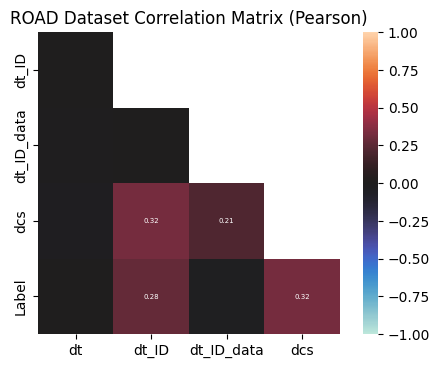

In [36]:
from plot_tools import plot_correlation_matrix

plot_correlation_matrix(df.drop(columns=["dataset", "type", "name", "class" "ID", "DLC", "t"], errors="ignore"))

In [37]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [38]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# index_normal = df.loc[df["Label"] == 0, (df.columns != "type") & (df.columns != "dataset") & (df.columns != "name") & (df.columns != "Label")]
scaler = StandardScaler(copy=True).fit(
    df.loc[df["Label"] == 0,
    (df.columns != "type") & (df.columns != "dataset") & (df.columns != "name") & (df.columns != "class") & (df.columns != "Label")]
)

df.loc[:, (df.columns != "type") & (df.columns != "dataset") & (df.columns != "name") & (df.columns != "class") & (df.columns != "Label")] = scaler.transform(
    df.loc[:, (df.columns != "type") & (df.columns != "dataset") & (df.columns != "name") & (df.columns != "class") & (df.columns != "Label")]
)

display(df)

,dt,dt_ID,dt_ID_data,dcs,name,class,dataset,type,Label
0,-0.019863,-0.228363,0.082567,0.300718,correlated_signal_attack_1,attack,ROAD,none,0
1,0.977014,-0.228366,-0.241872,0.300718,correlated_signal_attack_1,attack,ROAD,none,0
2,-0.680994,-0.144738,-0.269171,0.300718,correlated_signal_attack_1,attack,ROAD,none,0
3,-0.679442,-0.228363,-0.224753,0.300718,correlated_signal_attack_1,attack,ROAD,none,0
4,-0.681188,-0.228368,-0.099452,0.300718,correlated_signal_attack_1,attack,ROAD,none,0
...,...,...,...,...,...,...,...,...,...
5002299,-0.279246,-0.139533,-0.269038,-0.685287,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
5002300,-0.300197,-0.200713,-0.270602,-0.685287,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
5002301,-0.288946,-0.202494,-0.270648,-0.685287,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
5002302,0.025313,-0.208875,-0.270811,-0.685287,FreeDrivingData_20171231_Spark,Spark,Survival,none,0


In [39]:
# Stratify on the sub-dataset
X_train = df.drop(columns="name")
y_train = df["name"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=y_train)

# Use feature "Label" as classification label
d_temp: pd.DataFrame = pd.concat([X_train, y_train], axis="columns")
X_train, y_train = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp: pd.DataFrame = pd.concat([X_test, y_test], axis="columns")
X_test, y_test = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp = None # Release memory

In [40]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		150607		1426958
Attack		150607		64510


In [41]:
# X_test = X_test.loc[(X_test["type"] == "fuzz") | (X_test["type"] == "none")]
# y_test = y_test.loc[X_test.index]

In [42]:
# train_index = X_train.loc[X_train["dataset"] == "Survival"].index
# test_index = X_test.loc[X_test["dataset"] == "ROAD"].index
train_index = X_train.loc[(X_train["dataset"] == "Survival") & (X_train["name"] == "Fuzzy_dataset_SONATA")].index
test_index = X_test.loc[(X_test["dataset"] == "ROAD") & (X_test["name"] == "fuzzing_attack_1")].index

X_train = X_train.loc[train_index]
y_train = y_train.loc[train_index]

X_test = X_test.loc[test_index]
y_test = y_test.loc[test_index]

In [43]:
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

In [44]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300, max_features="log2", warm_start=True)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', max_leaf_nodes=300, n_estimators=20,
                       random_state=0, warm_start=True)

In [45]:
scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=10, n_jobs=-1)
print("Training F1: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

pred = clf.predict(X_test)

f1_scores = f1_score(y_test, pred, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Training F1: 0.9991 (+/- 0.0005)
Testing F1:  0.9679(+/- 0.0000)
Kappa score:  0.0271(+/- 0.0000)


Plot test data predictions

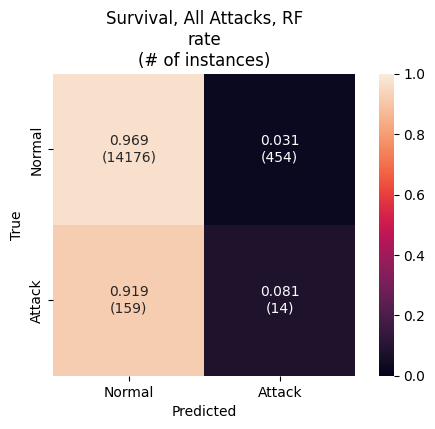

In [46]:
from plot_tools import plot_confusion_matrix

plot_confusion_matrix(y_test, pred, "Survival, All Attacks, RF\nrate\n(# of instances)")

Plot train data predictions

In [ ]:
pred_train = clf.predict(X_train)

plot_confusion_matrix(y_train, pred_train, "Survival, All Attacks, RF\nrate\n(# of instances)")

Add trees trained on the FPs and FNs

In [ ]:
clf.set_params(n_estimators=30) # Add another 20 trees for the FN and FPs
clf.fit(X_train.loc[y_train != pred_train], y_train.loc[y_train != pred_train])

Plot test data predictions again

In [ ]:
pred_test = clf.predict(X_test)

plot_confusion_matrix(y_test, pred_test, "Survival, All Attacks, RF\nrate\n(# of instances)")

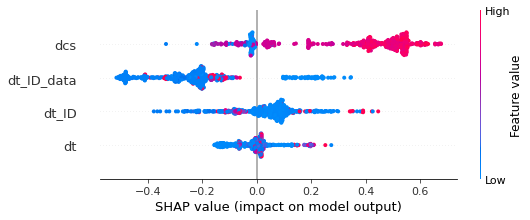

In [16]:
import shap
from shap_tools import *


exp = shap.TreeExplainer(clf)

# # Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# # same predictions as the original model
# assert np.abs(exp.model.predict(X_test_sample) - clf.predict_proba(X_test_sample)).max() < 1e-4

# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs(exp.expected_value + exp.shap_values(X_test_sample).sum(1) - clf.predict_proba(X_test_sample)).max() < 1e-4


shap_false = get_explanation(exp, X_test.loc[y_test != pred])
shap_true = get_explanation(exp, X_test.loc[y_test == pred])

plot_beeswarm(shap_false)

# shap_values = explainer(X_test.sample(1000, random_state=0))
# shap_values = shap.Explanation(shap_values[:, :, 1], feature_names=X_test.columns)

# shap.summary_plot(shap_values)


# shap.waterfall_plot(shap.Explanation(values=shap_values[int("which_class")][row], 
#                                          base_values=explainer.expected_value[int(which_class)], 
#                                          data=X_test.iloc[row],  # added this line
#                                          feature_names=X_test.columns.tolist()))
# shap.force_plot(explainer.expected_value[1], shap_values[1], features=X_test[:1], feature_names=X_test.columns)

# shap.plots.scatter(shap_values[:,"ones_w"])
# shap.summary_plot(shap_values[1], X_test.columns)

# plt.show()

In [ ]:
plot_beeswarm(shap_true)